# Forecasting in statsmodels

Questo notebook descrive le previsioni utilizzando modelli di serie temporali in statsmodels.

In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#importing dataset
australia = pd.read_csv('AUS.csv', header = 0)

new_names = {'Date': 'date', 'Location': 'location','MinTemp': 'min_temp', 
            'MaxTemp': 'max_temp', 'Rainfall':'rainfall', 'Evaporation': 'evaporation', 'Sunshine': 'sunshine', 
            'WindGustDir':'wind_gust_dir', 'WindGustSpeed': 'wind_gust_speed', 'WindDir9am': 'wind_dir_9am', 'WindDir3pm': 'wind_dir_3pm',
            'WindSpeed9am': 'wind_speed_9am', 'WindSpeed3pm': 'wind_speed_3pm',
            'Humidity9am':'humidity_9am', 'Humidity3pm':'humidity_3pm', 'Pressure9am':'pressure_9am', 'Pressure3pm':'pressure_3pm',
            'Cloud9am':'cloud_9am', 'Cloud3pm':'cloud_3pm', 'Temp9am':'temp_9am', 'Temp3pm':'temp_3pm',
            'RainToday': 'rain_today', 'RainTomorrow': 'rain_tomorrow' }
australia.rename(columns=new_names, inplace=True)
australia = australia.drop(['sunshine','evaporation'], axis=1)

#correzione del campo wind_dir e wind_speed: mettiamo 0 al posto di null ai campi dir se la velocità del vento è 0 (non c'è vento in quel momento)
australia['wind_dir_9am'] = australia[['wind_dir_9am','wind_speed_9am']].apply(lambda x: '0' if x['wind_speed_9am']==0 else x['wind_dir_9am'], axis=1)
australia['wind_dir_3pm'] = australia[['wind_dir_3pm','wind_speed_3pm']].apply(lambda x: '0' if x['wind_speed_3pm']==0 else x['wind_dir_3pm'], axis=1)

# rimuoviamo i gust perchè sono presi dalle colonne sopra, tra il massimo della giornata
australia = australia.drop(['wind_gust_dir','wind_gust_speed'], axis=1)

#togliamo tutte quelle città che hanno almeno il 40% di null sul campo cloud3pm
location = australia.location.unique()
#print(location)
count = 0
for loc in location:
    #print(loc, len(australia[australia['location']==loc]))
    lung = len(australia[australia['location']==loc])
    if australia[australia['location']==loc].isnull().sum().cloud_3pm > lung * 0.4:
        australia = australia.drop(australia[australia['location'] == loc].index)
        count +=1

#australia = australia.dropna(thresh = 16)
australia = australia.ffill(axis=0)

#aggiungiamo la colonna state in funzione della città 

#stati:
sa = ['Adelaide', 'MountGambier', 'Nuriootpa', 'Woomera'] #australia meridionale
wa = ['Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport', 'Perth', 'SalmonGums',
      'Walpole'] #australia occidentale
nsw = ['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'Penrith', 'Richmond', 'Sydney', 'SydneyAirport',
       'WaggaWagga', 'Williamtown', 'Wollongong'] #Nuovo Galles del Sud
qld = ['Brisbane', 'Cairns', 'GoldCoast', 'Townsville'] #Queensland
tas = ['Hobart', 'Launceston'] #Tasmania
vic = ['Ballarat', 'Bendigo', 'Sale', 'Melbourne', 'MelbourneAirport',
      'Mildura', 'Nhil', 'Portland', 'Watsonia', 'Dartmoor'] #Victoria
act = ['Camberra', 'Tuggeranong', 'MountGinini'] #territorio della capitale australiana
nt = [ 'AliceSprings', 'Darwin', 'Katherine', 'Uluru'] #Territorio del nord
nfk = ['NorfolkIsland'] #territorio esterno del norfolk
 
#gli ultimi quattro si potrebbero unire anche in un unico territorio del sud est australiano,
#a livello di clima dovrebbero essere molto simii potrebbe avere difficoltà a classificarli

def State(a):
    if a in sa:
        return 'SA'
    elif a in wa:
        return 'WA'
    elif a in nsw:
        return 'NSW'
    elif a in qld:
        return 'QLD'
    elif a in tas:
        return 'TAS'
    elif a in vic:
        return 'VIC'
    elif a in act:
        return 'ACT'
    elif a in nt:
        return 'NT'
    elif a in nfk:
        return 'NFK'
    

#le = preprocessing.LabelEncoder()
#crime['category_id'] = le.fit_transform(australia['state'])

australia['state'] = australia.location.apply(lambda x: str(State(x)))


### Preprocessing 

In [2]:
#set della data come indice
australia['date'] = pd.to_datetime(australia['date'], infer_datetime_format=True)
australia = australia.set_index(['date'])

# scegliamo una tra tutte le città del nostro dataset 
aus1= australia[australia['location'] == 'Sydney']
aus2 = aus1.drop(aus1.columns.difference(['rainfall']), 1)

aus2.head()

,rainfall
date,
2008-02-01,15.6
2008-02-02,6.0
2008-02-03,6.6
2008-02-04,18.8
2008-02-05,77.4


<AxesSubplot:xlabel='date'>

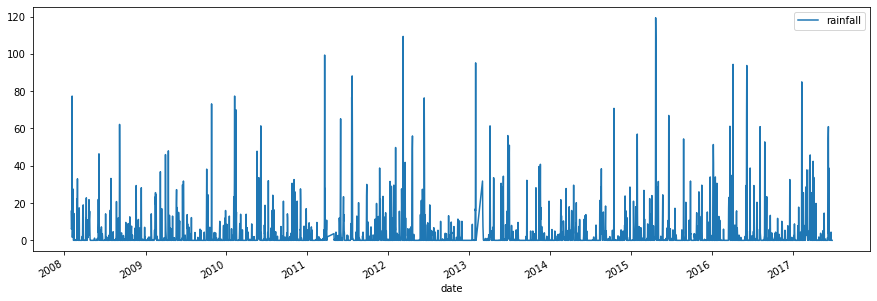

In [3]:
#plot della rainfall per la città Sydney
from datetime import datetime
aus2.plot( y ='rainfall', figsize=(15, 5))

In [4]:
# prendiamo un intervallo del dataset, che non contiene buchi temporali

from datetime import datetime
date_string1 = '2014-01-01'
dat1 = datetime.fromisoformat(date_string1)
date_string2 = '2017-01-01'
dat2 = datetime.fromisoformat(date_string2)
aus3= aus2[aus2.index >= dat1]
aus3= aus3[aus3.index < dat2]
len(aus3)

1096

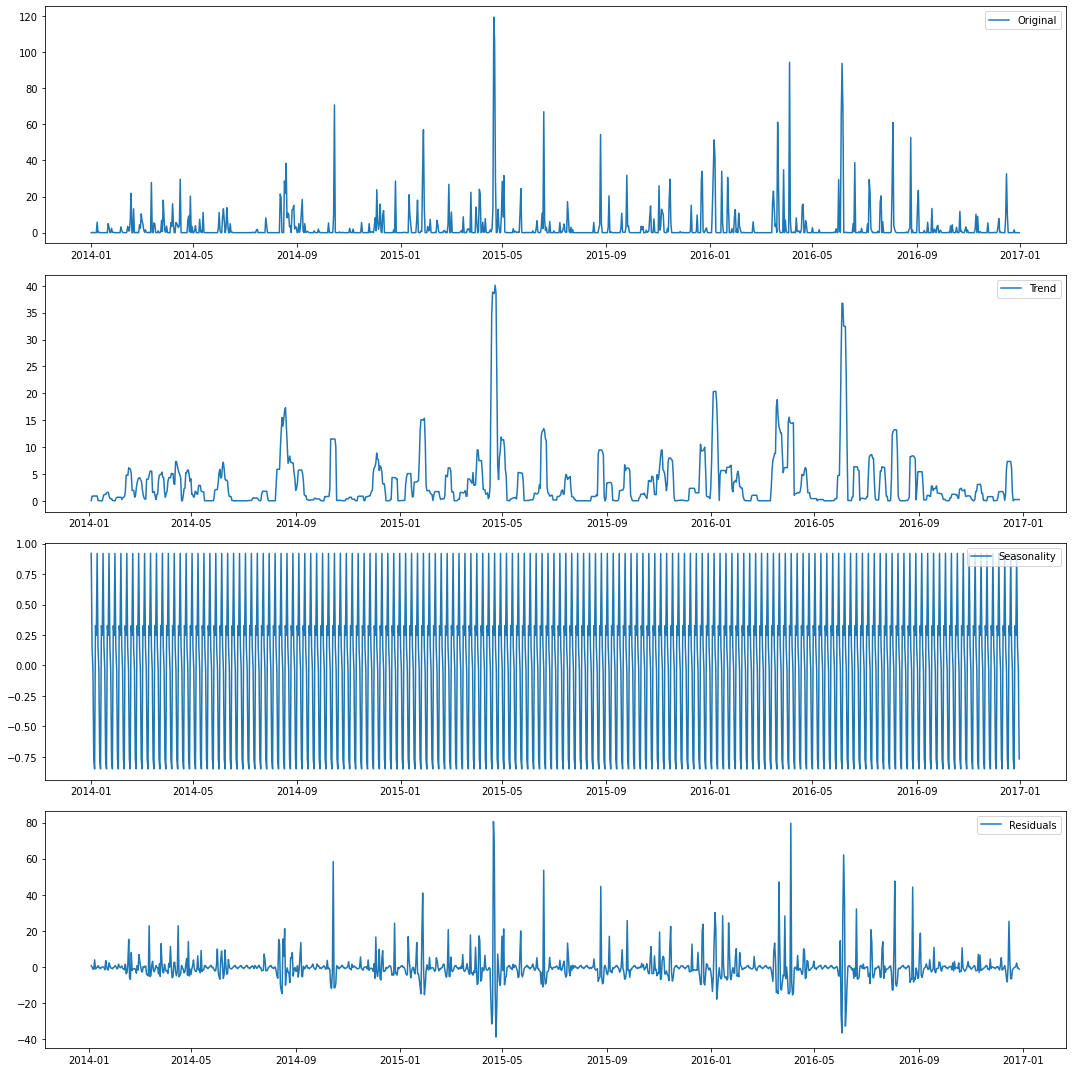

In [5]:
# facciamo una decomposizione additiva della serie temporale nelle sue 4 componenti

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(aus3.rainfall, model = 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,15))

plt.subplot(411)
plt.plot(aus3.rainfall, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

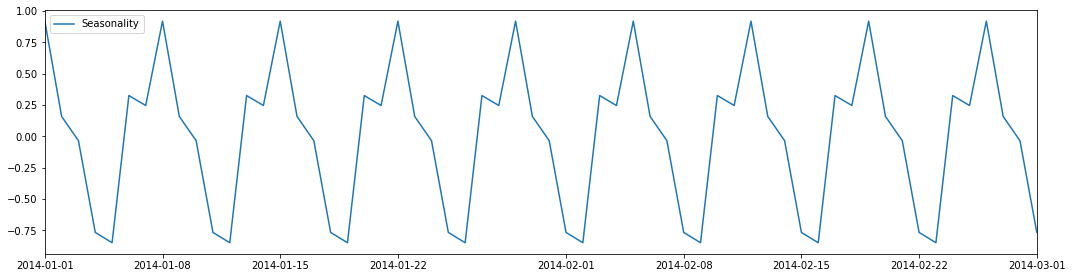

In [6]:

from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(aus3.rainfall, model = 'additive')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

dfrom = '2014-01-01'
dfm = datetime.fromisoformat(dfrom)
dto = '2014-03-01'
dto = datetime.fromisoformat(dto)

plt.figure(figsize=(15,15))

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.xlim([dfm, dto])
plt.legend(loc='best')


plt.tight_layout()


# STATIONARY TEST

#### ADF Test

In [7]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(aus3.rainfall.dropna())

print('ADF Statistic: %f' %result[0])
print('p-value: %f' % result[1])

ADF Statistic: -19.871087
p-value: 0.000000


#### Phillips-Perron Testing

In [8]:
from arch.unitroot import PhillipsPerron

pp = PhillipsPerron(aus3.rainfall)
print(pp.summary().as_text())

     Phillips-Perron Test (Z-tau)    
Test Statistic                -21.609
P-value                         0.000
Lags                               22
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


### La serie stazionaria poichè il p-value < 0.05. Quindi settiamo d = 0

# Definizione dei parametri p, q per ARIMA

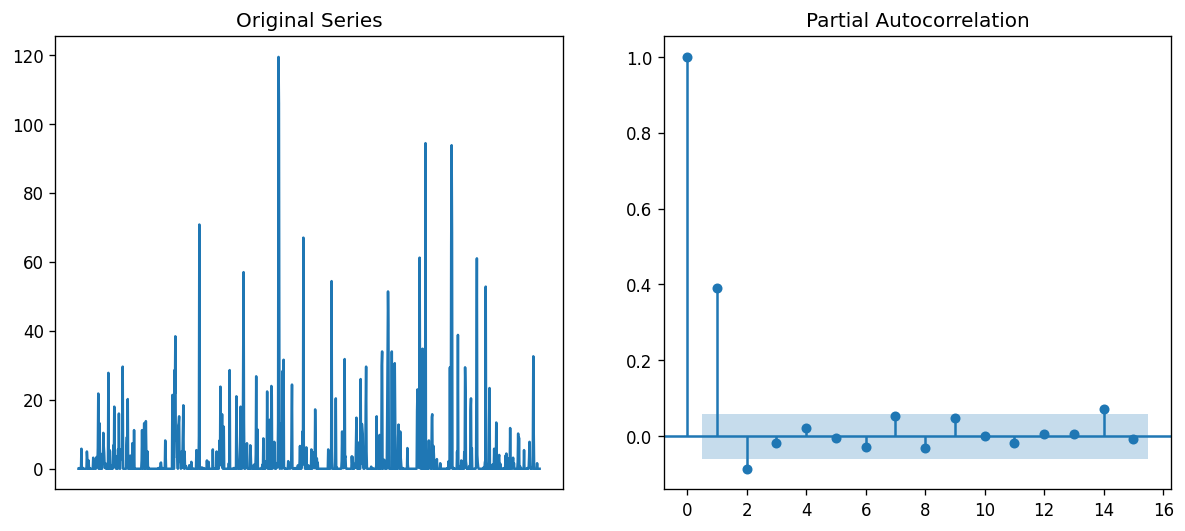

In [9]:
#par

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plt.rcParams.update({'figure.figsize':(12,5),'figure.dpi':120})

fig, axes = plt.subplots(1,2)
axes[0].plot(aus3.rainfall); axes[0].set_title('Original Series')
axes[0].get_xaxis().set_visible(False)

plot_pacf(aus3.rainfall, ax=axes[1], lags = 15)

plt.show()

#### il valore per noi interessante è p=1 poichè è quello che esce dall'area di significatività in modo evidente e impatta maggiormente sul valore attuale rispetto tutti gli altri.
> p = 1

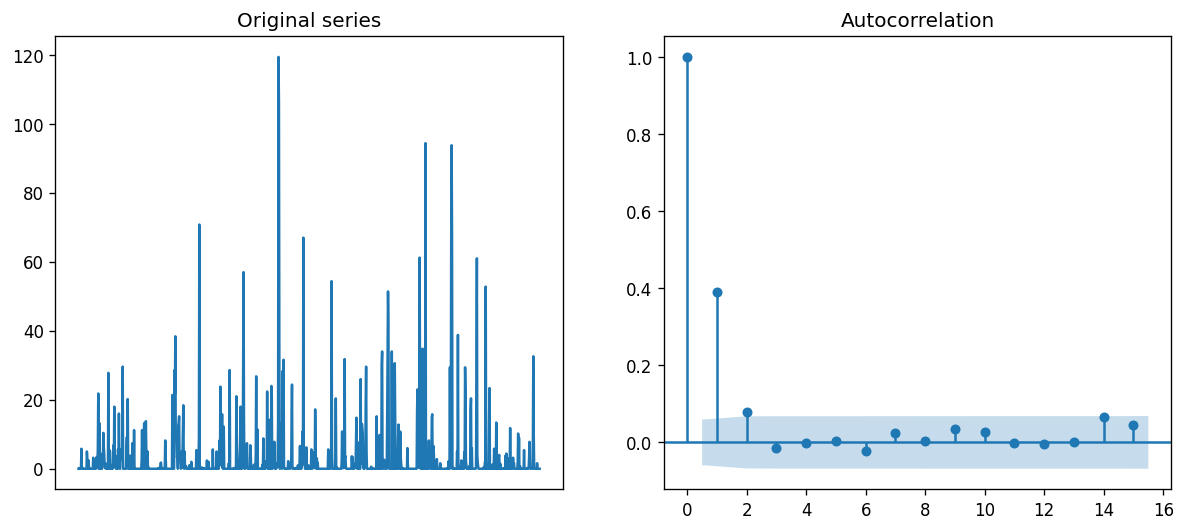

In [10]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize': (12, 5), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2)
axes[0].plot(aus3.rainfall); axes[0].set_title('Original series')
axes[0].get_xaxis().set_visible(False)
plot_acf(aus3.rainfall, ax=axes[1],lags=15)

plt.show()

#### Il valore per noi interessante è q=1 poichè è quello che esce dall'area di significatività in modo evidente e impatta maggiormente sul valore attuale rispetto tutti gli altri. 
> q = 1,2

## Train - Test Split

In [11]:
from statsmodels.tsa.stattools import acf

l = int(len(aus3)*0.75)
train = aus3[:l]
test = aus3[l:]
print(l, len(aus3)-l)

822 274


# ARIMA

In [12]:
from statsmodels.tsa.arima_model import ARIMA

# Construct the model
model1 = ARIMA(aus3.rainfall, order=(1, 0, 1)) # p, d, q
# Estimate the parameters
model_fit1 = model1.fit(disp = 0)

print(model_fit1.summary())

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:               rainfall   No. Observations:                 1096
Model:                     ARMA(1, 1)   Log Likelihood               -4010.290
Method:                       css-mle   S.D. of innovations              9.393
Date:                Mon, 15 Mar 2021   AIC                           8028.580
Time:                        19:37:05   BIC                           8048.577
Sample:                    01-01-2014   HQIC                          8036.146
                         - 12-31-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3018      0.440      7.505      0.000       2.440       4.164
ar.L1.rainfall     0.2366      0.067      3.510      0.000       0.104       0.369
ma.L1.rainfall     0.1841      0.067

In [13]:
from statsmodels.tsa.arima_model import ARIMA

# Construct the model
model2 = ARIMA(aus3.rainfall, order=(1, 0, 2)) # p, d, q
# Estimate the parameters
model_fit2 = model2.fit(disp = 0)

print(model_fit2.summary())

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                              ARMA Model Results                              
Dep. Variable:               rainfall   No. Observations:                 1096
Model:                     ARMA(1, 2)   Log Likelihood               -4009.288
Method:                       css-mle   S.D. of innovations              9.385
Date:                Mon, 15 Mar 2021   AIC                           8028.577
Time:                        19:37:06   BIC                           8053.574
Sample:                    01-01-2014   HQIC                          8038.035
                         - 12-31-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3022      0.431      7.666      0.000       2.458       4.146
ar.L1.rainfall    -0.1157      0.220     -0.526      0.599      -0.547       0.316
ma.L1.rainfall     0.5389      0.218

# Grid Search

In [14]:
import pmdarima as pm
sxmodel = pm.auto_arima(aus3.rainfall,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=1, max_q=2, m=7,
                           start_P=0, seasonal=True,
                           d=None, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

# se numero di stagionalità > 0 --> P > 0
# se serie è stazionaria --> D = 1 altrimenti D = 0
# se numero di stagionalità > 0 --> Q = 0
# P + Q <= 2

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.38 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=8893.964, Time=0.06 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=8365.978, Time=0.65 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=8891.964, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[7] intercept   : AIC=8695.514, Time=0.22 sec
 ARIMA(1,0,0)(2,1,0)[7] intercept   : AIC=8265.978, Time=1.36 sec
 ARIMA(1,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=3.97 sec
 ARIMA(1,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=8457.633, Time=0.81 sec
 ARIMA(1,0,1)(2,1,0)[7] intercept   : AIC=8258.814, Time=1.45 sec
 ARIMA(1,0,1)(1,1,0)[7] intercept   : AIC=8355.893, Time=0.69 sec
 ARIMA(1,0,1)(2,1,1)[7] intercept   : AIC=inf, Time=4.51 sec
 ARIMA(1,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=8268.167, Time=1.39 s

# ARIMA (0,0,2)

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Construct the model
model3 = ARIMA(aus3.rainfall, order=(0, 0, 2)) # p, d, q
# Estimate the parameters
model_fit3 = model3.fit(disp = 0)

print(model_fit3.summary())

                              ARMA Model Results                              
Dep. Variable:               rainfall   No. Observations:                 1096
Model:                     ARMA(0, 2)   Log Likelihood               -4009.412
Method:                       css-mle   S.D. of innovations              9.386
Date:                Mon, 15 Mar 2021   AIC                           8026.824
Time:                        19:48:07   BIC                           8046.822
Sample:                    01-01-2014   HQIC                          8034.390
                         - 12-31-2016                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              3.3020      0.435      7.583      0.000       2.449       4.155
ma.L1.rainfall     0.4248      0.030     14.066      0.000       0.366       0.484
ma.L2.rainfall     0.1117      0.031

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


# SARIMA (0, 0, 2) (2, 1, 0, 7)

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Construct the model
model6 = SARIMAX(aus3.rainfall, order=(0, 0, 2),  seasonal_order=(2, 1, 0, 7))
# Estimate the parameters
model_fit6 = model6.fit()

print(model_fit6.summary())

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                                     SARIMAX Results                                      
Dep. Variable:                           rainfall   No. Observations:                 1096
Model:             SARIMAX(0, 0, 2)x(2, 1, [], 7)   Log Likelihood               -4122.707
Date:                            Mon, 15 Mar 2021   AIC                           8255.415
Time:                                    19:37:46   BIC                           8280.380
Sample:                                01-01-2014   HQIC                          8264.864
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.4432      0.014     32.224      0.000       0.416       0.470
ma.L2          0.1103      0.027   

# RESIDUALS FOR ARIMA AND SARIMA

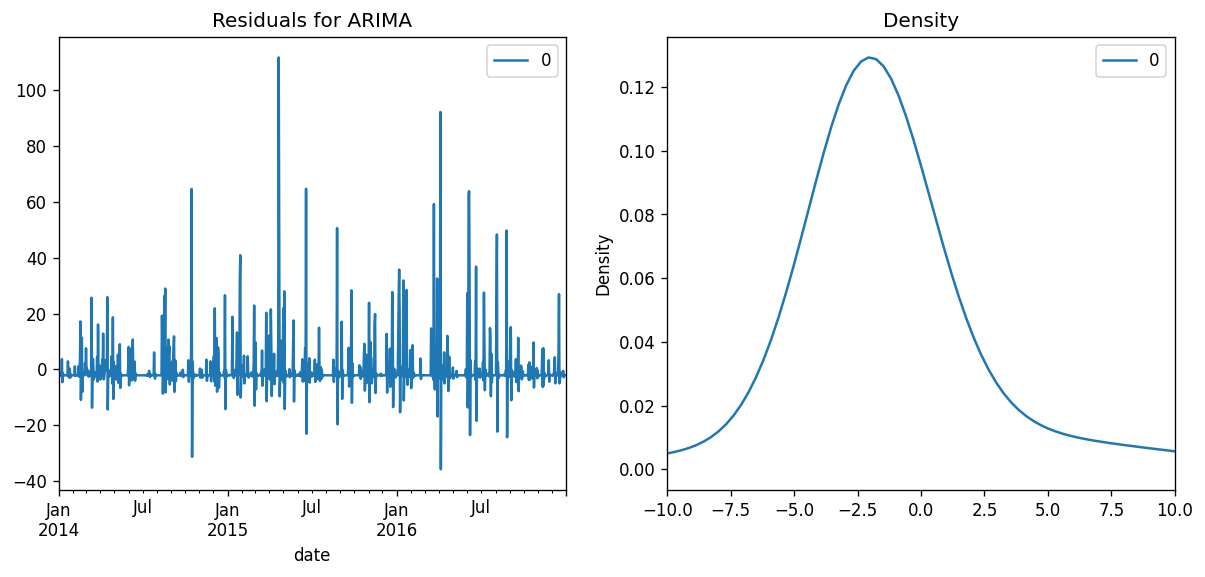

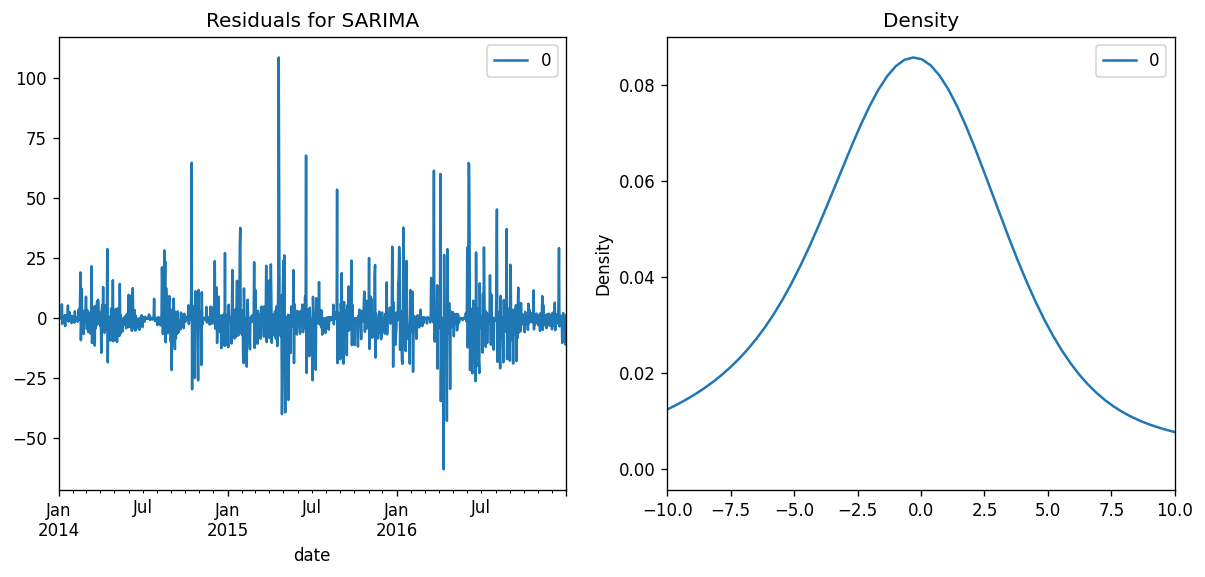

In [17]:
residuals = pd.DataFrame(model_fit3.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals for ARIMA", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

residuals = pd.DataFrame(model_fit6.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals for SARIMA", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

# FORECAST FOR ARIMA AND SARIMA

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


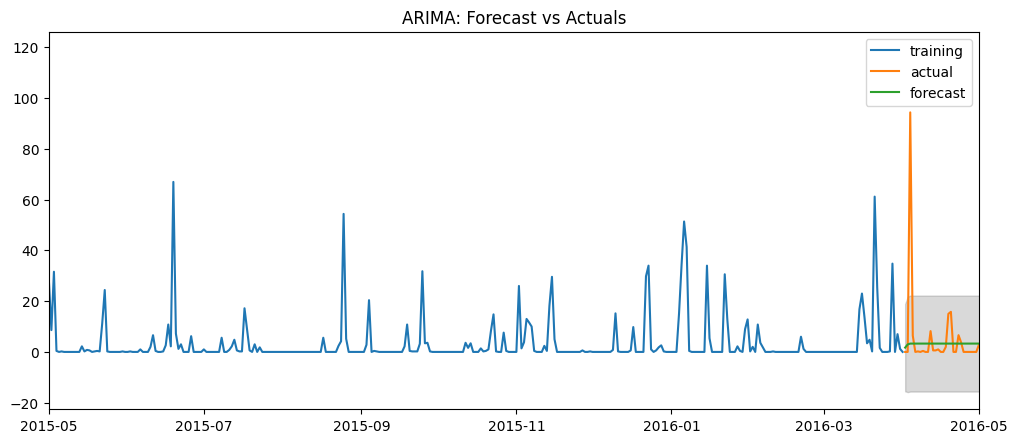

In [18]:
#ARIMA MODEL
model3 = ARIMA(train.rainfall, order=(0,0,2))
fitted = model3.fit(disp=-1)

#forecast
fc,se, conf = fitted.forecast(len(test), alpha=0.05) #95% conf

#make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:,0], index=test.index)
upper_series = pd.Series(conf[:,1], index=test.index)

#plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train.rainfall, label='training')
plt.plot(test.rainfall, label='actual')
plt.plot(fc_series, label='forecast')

plt.fill_between(lower_series.index, lower_series, upper_series,color='k', alpha=.15)
plt.title('ARIMA: Forecast vs Actuals')
plt.legend(loc='best')
# plt.legend(loc='uooer keft', fitsize=8)


dfrom = '2015-05-01'
dfm = datetime.fromisoformat(dfrom)
dto = '2016-05-01'
dto = datetime.fromisoformat(dto)
plt.xlim([dfm, dto])

plt.show()

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


(16556.0, 16922.0)

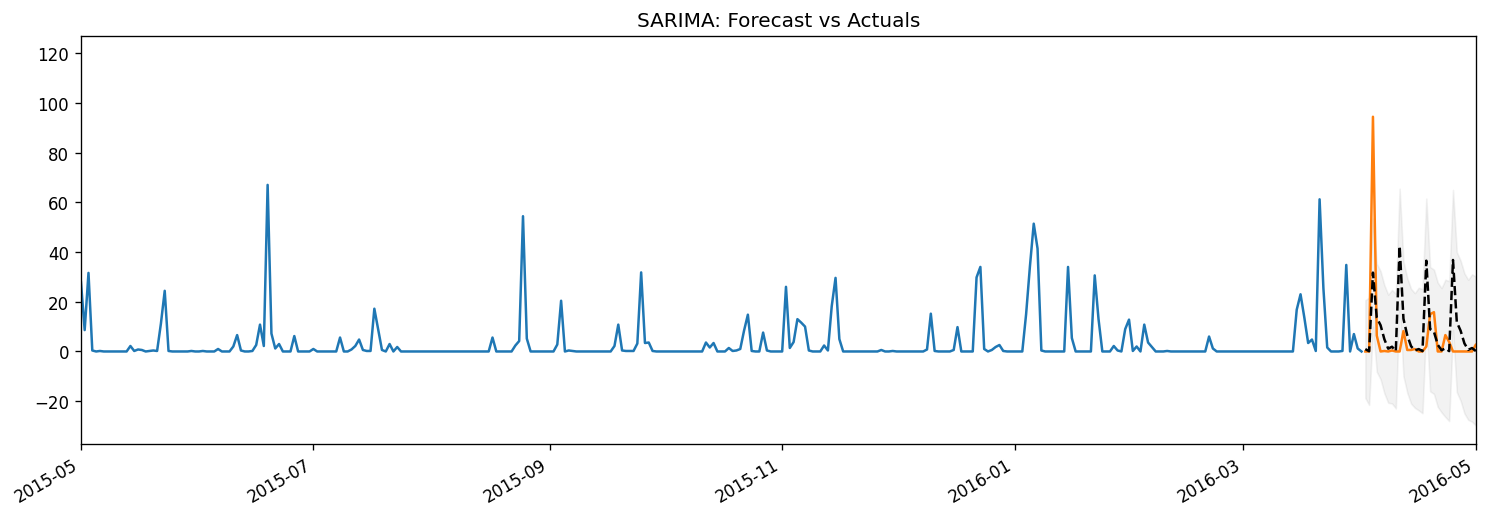

In [19]:
import statsmodels.api as sm
model7 = sm.tsa.SARIMAX(train.rainfall, order=(0,0,2), seasonal_order = (2,1,0,7)) 
res = model7.fit(start=test.index[0], end=test.index[-1]) #fittiamo il modello per stimare i parametri

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train.index, train.rainfall, label='Train')
plt.plot(test.index, test.rainfall, label='Test')
plt.title('SARIMA: Forecast vs Actuals')

fcast = res.get_forecast(30).summary_frame() #prendo il 'summary_frame' perchè voglio plottare l'area di confidenza
fcast['mean'].plot(ax=ax, style='k--') #plotto la linea tratteggiata come la previsione fatta dal modello
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.05); #per poter plottare l'intervallo di confidenza inferiore e superiore

dfrom = '2015-05-01'
dfm = datetime.fromisoformat(dfrom)
dto = '2016-05-01'
dto = datetime.fromisoformat(dto)
plt.xlim([dfm, dto])

#plt.ylim([-5, 50])

# MODEL ACCURACY SCORE FOR SARIMA

In [23]:
def forecast_accuracy(forecast, actual):

    rmse= np.mean((forecast - actual)**2)**.5 #RMSE
    mbe = np.mean(forecast - actual) #MBE
    mae= np.mean(np.abs(forecast - actual)) #MAE
    
    #R-squared
    corr_matrix = np.corrcoef(actual, forecast)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    
    return({'RMSE':rmse, 'MBE':mbe, 'MAE':mae, 'R-squared':R_sq })
    
forecast_accuracy(np.array(fcast['mean']), test.rainfall[:30].values)
    

{'RMSE': 17.22420888480143,
 'MBE': 3.1096528937572527,
 'MAE': 9.030891630672603,
 'R-squared': 0.130653951299761}

# HWES

In [38]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing #HWES

model_hwes1 = ExponentialSmoothing(aus3.rainfall, seasonal='add', seasonal_periods=7)
hwes_fit1 = model_hwes1.fit()

print(hwes_fit1.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                 rainfall   No. Observations:                 1096
Model:             ExponentialSmoothing   SSE                         114558.901
Optimized:                         True   AIC                           5113.766
Trend:                             None   BIC                           5158.761
Seasonal:                      Additive   AICC                          5114.010
Seasonal Periods:                     7   Date:                 Mon, 15 Mar 2021
Box-Cox:                          False   Time:                         19:50:48
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0874632                alpha                 True
smoothing_seasonal       

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


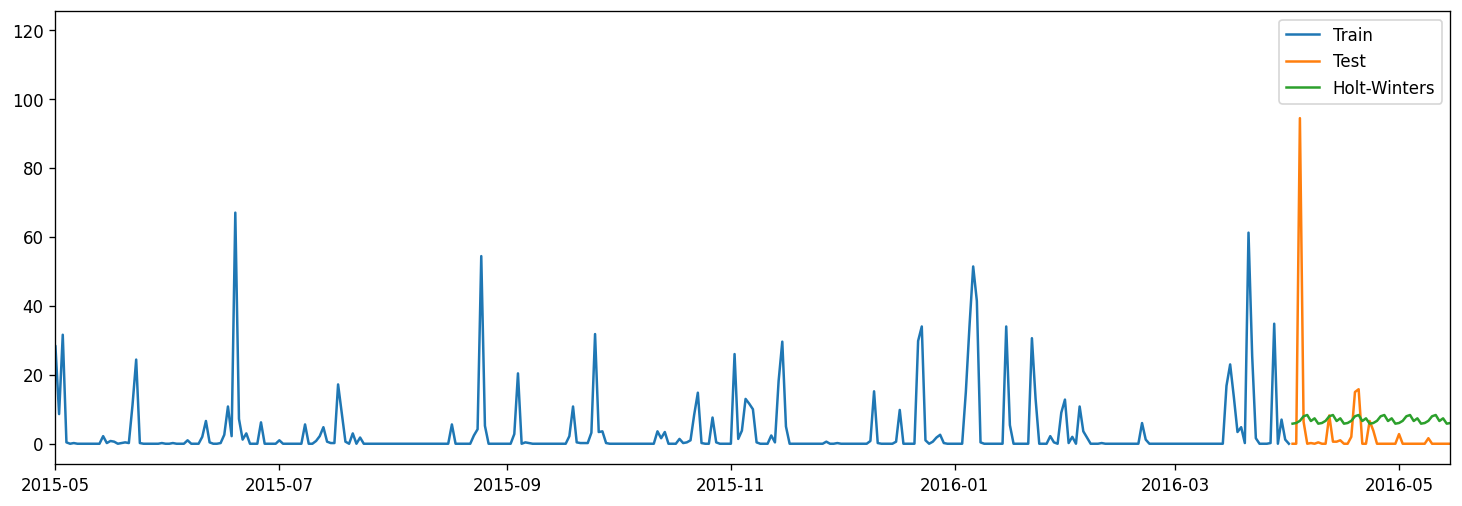

In [39]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hwes1 = ExponentialSmoothing(train.rainfall, seasonal='add', seasonal_periods=7).fit()
pred = model_hwes1.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train.index, train.rainfall, label='Train')
plt.plot(test.index, test.rainfall, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')

dfrom = '2015-05-01'
dfm = datetime.fromisoformat(dfrom)
dto = '2016-05-15'
dto = datetime.fromisoformat(dto)
plt.xlim([dfm, dto])

plt.legend(loc='best')

In [40]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing #HWES

model_hwes2 = ExponentialSmoothing(aus3.rainfall, seasonal='add', seasonal_periods=365)
hwes_fit2 = model_hwes2.fit()

print(hwes_fit2.summary())

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


                       ExponentialSmoothing Model Results                       
Dep. Variable:                 rainfall   No. Observations:                 1096
Model:             ExponentialSmoothing   SSE                          76168.542
Optimized:                         True   AIC                           5382.444
Trend:                             None   BIC                           7217.232
Seasonal:                      Additive   AICC                          5758.560
Seasonal Periods:                   365   Date:                 Mon, 15 Mar 2021
Box-Cox:                          False   Time:                         19:51:53
Box-Cox Coeff.:                    None                                         
                           coeff                 code              optimized      
----------------------------------------------------------------------------------
smoothing_level                0.1273081                alpha                 True
smoothing_seasonal    

C:\Users\angel\AppData\Roaming\Python\Python38\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


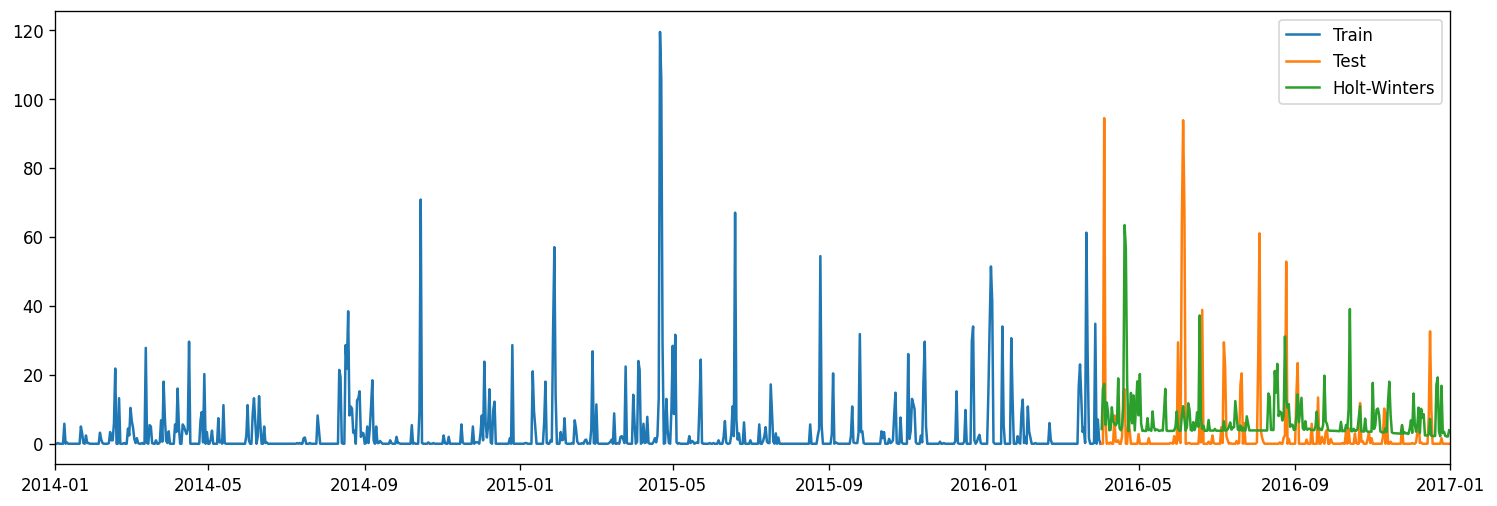

In [43]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hwes2 = ExponentialSmoothing(train.rainfall, seasonal='add', seasonal_periods=365).fit()
pred = model_hwes2.predict(start=test.index[0], end=test.index[-1])

fig, ax = plt.subplots(figsize=(15, 5))
plt.plot(train.index, train.rainfall, label='Train')
plt.plot(test.index, test.rainfall, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')

dfrom = '2014-01-01'
dfm = datetime.fromisoformat(dfrom)
dto = '2017-01-01'
dto = datetime.fromisoformat(dto)
plt.xlim([dfm, dto])

plt.legend(loc='best')

# RESIDUALS FOR HWES

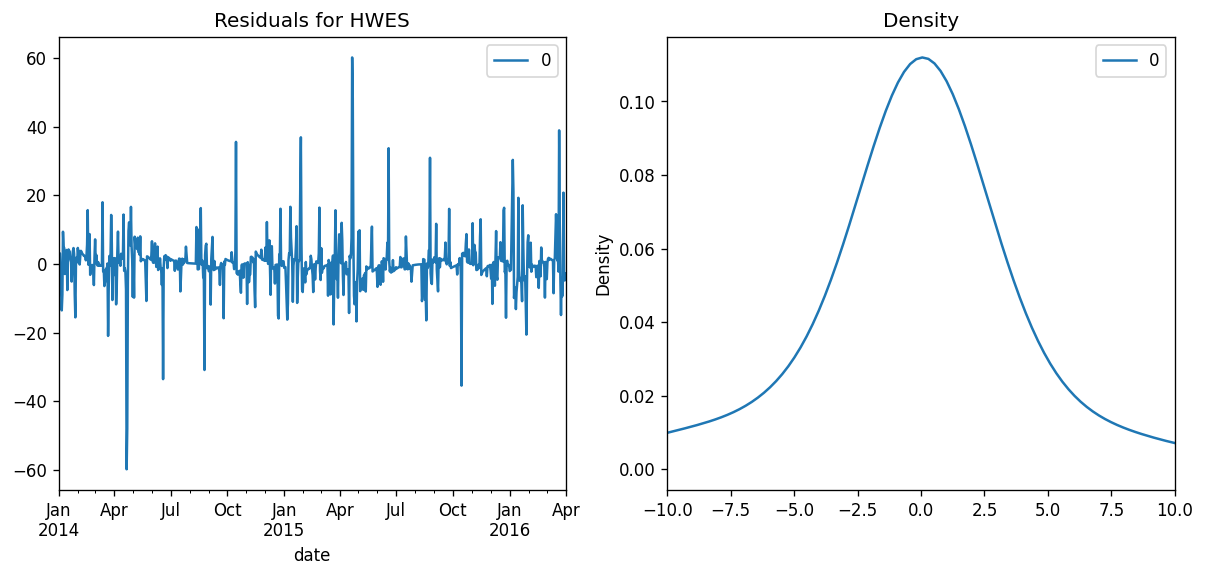

In [44]:
residuals = pd.DataFrame(model_hwes2.resid)
rig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals for HWES", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
ax[1].set(xlim=(-10,10))
plt.show()

# MODEL ACCURACY SCORE FOR HWES

In [46]:
def forecast_accuracy(forecast, actual):

    rmse= np.mean((forecast - actual)**2)**.5 #RMSE
    mbe = np.mean(forecast - actual) #MBE
    mae= np.mean(np.abs(forecast - actual)) #MAE
    
    #R-squared
    corr_matrix = np.corrcoef(actual, forecast)
    corr = corr_matrix[0,1]
    R_sq = corr**2
    
    return({'RMSE':rmse, 'MBE':mbe, 'MAE':mae, 'R-squared':R_sq })
    
forecast_accuracy(np.array(pred), test.rainfall.values)
    

{'RMSE': 13.508447497897132,
 'MBE': 3.4342999180587777,
 'MAE': 7.945834113953157,
 'R-squared': 0.011019721424521395}